<center> <h1> Machine Translation Idea Approach

### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

We know that the strain has values which are between $[-0.2,0.2]$ and the stress has values between $[-1400,1400]$ (approx.). Neural Machine Translation has been a hot topic for the past few years and many different architectures have been implemented to operate translations between different languages. Our idea here is to apply these concepts to two "new" languages : strain and stress. In order to perform such a task, we need the following :
* functions to discretize the span of values for both strain and stress : **values to "words"**
* functions to go from **"words" to values**
* functions to measure the **loss** after a two step conversion : value $\rightarrow$ word $\rightarrow$ value
* functions to plot results into a **grid** once space was discretized  

The above will be put in a class called **CONVERTER**  

The next part involves **generating a very large dataset of sentences**. To perform this task, we will use the different types of strains we previously created, we will build new types of strains and use the ARMA strains which are easily generated. We really need to think about the size of the vocabulary to estimate the number of sentences we need to train the model. Note that the size of the vocabulary is linked to the precision of our conversion.  

Finally, we will train a sequence-2-sequence model using **tensorflow** : https://www.tensorflow.org/tutorials/seq2seq

### I. Converter Class : Generic Basic Class

In [2]:
class converter:
    def __init__(self,min_value,max_value,size_vocab):
        self.eps=10**(-10)
        self.min_value=min_value
        self.max_value=max_value
        self.size_vocab=size_vocab
        self.bins=np.linspace(min_value-self.eps,max_value+self.eps,size_vocab+1)
        self.vocab = list(range(size_vocab))
    
    def to_words(self,array):
        return np.digitize(array,self.bins)
    
    def to_values(self,array):
        f = lambda t: (self.bins[t-1]+self.bins[t])/2
        f = np.vectorize(f)
        return f(array)
    
    def info(self):
        print('Min Value:',self.min_value)
        print('Max Value:',self.max_value)
        print('Correction term:',self.eps)
        print('Dictionary/Vocabulary size:',self.size_vocab)
        a=np.random.random(1000)
        a=0.2*a/np.max(a)
        noise=abs(self.to_values(self.to_words(a))-a)
        print('Average error in conversion given 1000 random values:',noise.mean())

#### Example :

In [3]:
import random
test = np.array([[random.uniform(-0.2,0.2) for i in range(10)] for j in range(10)])
print('Example - Each line is a ten observation strain :')
print('')
print(np.round(test,decimals=2))

Example - Each line is a ten observation strain :

[[ 0.13  0.07  0.19  0.02  0.2   0.15  0.05 -0.04 -0.07  0.15]
 [ 0.1   0.17  0.05  0.03  0.16 -0.05  0.05  0.14  0.18 -0.11]
 [-0.09  0.01  0.03 -0.12  0.06  0.17 -0.1  -0.06 -0.16 -0.14]
 [ 0.05 -0.18 -0.04  0.06  0.11  0.18 -0.1   0.04 -0.09  0.02]
 [-0.12 -0.06 -0.05 -0.14 -0.2  -0.02 -0.03 -0.03 -0.07  0.11]
 [-0.11  0.18  0.12  0.    0.11 -0.19  0.15 -0.   -0.14  0.07]
 [ 0.1  -0.17 -0.12  0.13  0.08 -0.1   0.13  0.09 -0.1  -0.2 ]
 [ 0.12  0.01 -0.14  0.09  0.09 -0.12  0.16  0.09  0.11  0.17]
 [ 0.    0.08  0.02  0.13  0.12 -0.09 -0.18  0.08  0.01 -0.16]
 [ 0.18  0.01 -0.18 -0.01  0.17  0.16 -0.02 -0.14  0.03 -0.18]]


In [4]:
convert=converter(-0.2,0.2,10)
convert.info()

Min Value: -0.2
Max Value: 0.2
Correction term: 1e-10
Dictionary/Vocabulary size: 10
Average error in conversion given 1000 random values: 0.010341281310379842


In [5]:
print('Each line is now a sentence with its words :')
print('')
print(convert.to_words(test))

Each line is now a sentence with its words :

[[ 9  7 10  6 10  9  7  4  4  9]
 [ 8 10  7  6  9  4  7  9 10  3]
 [ 3  6  6  3  7 10  3  4  1  2]
 [ 7  1  4  7  8 10  3  6  3  6]
 [ 2  4  4  2  1  5  5  5  4  8]
 [ 3 10  8  6  8  1  9  5  2  7]
 [ 8  1  2  9  8  3  9  8  3  1]
 [ 8  6  2  8  8  3 10  8  8 10]
 [ 6  8  6  9  8  3  1  8  6  2]
 [10  6  1  5 10  9  5  2  6  1]]


### II. Converter Class : Constructing Grid/Plot Function for Quick Analysis

In [6]:
def plot_st(truth,model,sentence_stress=None):
    """ 
    Truth: tuple(strain,stress)
    Model: tuple(sentence_converted_strain,sentence_converted_stress)
    
    """
    if sentence_stress==None:
        plt.rcParams["figure.figsize"] = (16,8)
        grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)
        plt.subplot(grid[:2,:1])
        plt.plot(truth[0],truth[1],color='blue',label='truth')
        plt.scatter(model[0],model[1],color='red',label='prediction')
        plt.xlabel('$\epsilon$')
        plt.ylabel('$\sigma$')
        plt.legend()
        plt.title('Stress Strain Diagram : Sentence Analysis')

        x1=range(len(truth[0]))
        plt.subplot(grid[0,1])
        plt.scatter(x1,abs(truth[0]-model[0]),color='#158fff')
        plt.xlabel('$t$')
        plt.ylabel('$\epsilon$')
        plt.title('Strain Residuals')

        x2=range(len(truth[1]))
        plt.subplot(grid[1,1])
        plt.scatter(x1,abs(truth[1]-model[1]),color='#158fff')
        plt.xlabel('$t$')
        plt.ylabel('$\sigma$')
        plt.title('Stress Residuals')
        plt.show()
    else:
        plt.rcParams["figure.figsize"] = (16,8)
        grid = plt.GridSpec(3, 2, wspace=0.4, hspace=0.3)
        plt.subplot(grid[:2,:1])
        plt.plot(truth[0],truth[1],color='blue',label='truth')
        plt.scatter(model[0],model[1],color='red',label='prediction')
        plt.xlabel('$\epsilon$')
        plt.ylabel('$\sigma$')
        plt.legend()
        plt.title('Stress Strain Diagram : Sentence Analysis')

        x1=range(len(truth[0]))
        plt.subplot(grid[0,1])
        plt.scatter(x1,abs(truth[0]-model[0]),color='#158fff')
        plt.xlabel('$t$')
        plt.ylabel('$\epsilon$')
        plt.title('Strain Residuals')

        x2=range(len(truth[1]))
        plt.subplot(grid[1,1])
        plt.scatter(x1,abs(truth[1]-model[1]),color='#158fff')
        plt.xlabel('$t$')
        plt.ylabel('$\sigma$')
        plt.title('Stress Residuals')
        
        # Deserves still a bit of work to perfect this idea
        plt.subplot(grid[2,:2])
        a=(np.equal(sentence_stress[0],sentence_stress[1])-0.5)*10
        data=np.array([a,a])
        plt.imshow(data)
        plt.title('Stress Prediction')
        
        plt.show()        

#### Example :

In [7]:
import nbimporter
from Functions import strain_linear,B20_strain_linear, RMA_newton
strain_test=B20_strain_linear(20)
E = 200000 ; b = 0.001 ; A = 1000 ;a = 0.2 ; rma=RMA_newton(strain_test) ; rma.activate(E,A,b,a)
stress_test=rma.stress
strain_test=np.array(strain_test)
stress_test=np.array(stress_test)

Importing Jupyter notebook from Functions.ipynb


In [8]:
# Stress
max_stress=int(stress_test.max())+1 ; min_stress=int(stress_test.min())-1 ; size_vocab_stress=15000
stress_convert=converter(min_stress,max_stress,size_vocab_stress)
# Strain
max_strain=0.2 ; min_strain=-0.2 ; size_vocab_strain=15000
strain_convert=converter(min_strain,max_strain,size_vocab_strain)

In [9]:
strain_converted=strain_convert.to_values(strain_convert.to_words(strain_test))
stress_converted=stress_convert.to_values(stress_convert.to_words(stress_test))

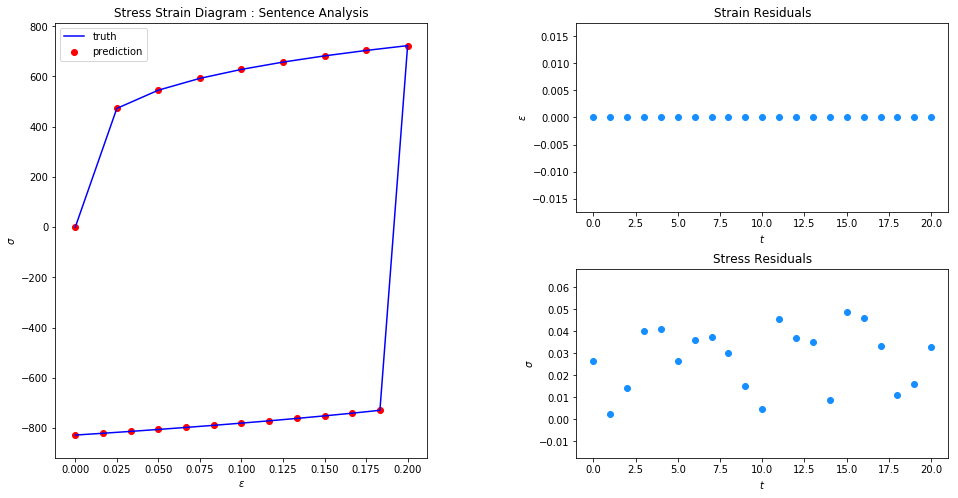

In [11]:
tru=(strain_test,stress_test) ; mod=(strain_converted,stress_converted)
sent=(stress_convert.to_words(stress_test),stress_convert.to_words(stress_test))
plot_st(tru,mod)